# Weather Demo

This is an example of some basic data analysis of a messy, real-world data source from [the weather station on the Computer Laboratory roof](https://www.cl.cam.ac.uk/weather/)!

In [50]:
import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.dates
import pandas as pd
import requests
import seaborn as sns

WEATHER_DATA_FILE = "weather-raw.csv"

First up, download the data if we don't already have a local copy. Then load it in to a pandas dataframe.

In [51]:
if not os.path.exists(WEATHER_DATA_FILE):
    csv_request = requests.get("https://www.cl.cam.ac.uk/weather/weather-raw.csv")
    csv_request.raise_for_status()
    with open(WEATHER_DATA_FILE, "wb") as f:
        f.write(csv_request.content)
    
columns = ["timestamp", "temperature", "humidity", "dew_point", "pressure", "avg_wind_speed", "avg_wind_bearing", "sunshine", "rainfall", "max_wind_speed"]

df = pd.read_csv(WEATHER_DATA_FILE, names=columns, parse_dates=[0])

# Show the first five rows, those are some warm days!
df[:5]

,timestamp,temperature,humidity,dew_point,pressure,avg_wind_speed,avg_wind_bearing,sunshine,rainfall,max_wind_speed
0,1995-06-30 15:00:00,295.0,43.0,156.0,1013.0,14.0,225.0,1044,0,14.0
1,1995-06-30 15:30:00,305.0,36.0,140.0,1013.0,13.0,315.0,50,0,13.0
2,1995-06-30 16:00:00,311.0,41.0,163.0,1013.0,12.0,315.0,51,0,12.0
3,1995-06-30 16:30:00,322.0,43.0,181.0,1013.0,2.0,315.0,50,0,2.0
4,1995-06-30 17:00:00,327.0,41.0,178.0,1013.0,8.0,225.0,51,0,8.0


The weather station database that this CSV derives from has floating point values stored as integers for precision and space-saving reasons. 

We can divide out the relevant factors, using both a nice syntax and efficient under-the-hood computation.

Previewing shows that our temperatures seem more reasonable now:

In [52]:
df["temperature"] /= 10
df["dew_point"] /= 10
df["avg_wind_speed"] /= 10
df["sunshine"] /= 100
df["rainfall"] /= 1000
df["max_wind_speed"] /= 10

df[:5]

,timestamp,temperature,humidity,dew_point,pressure,avg_wind_speed,avg_wind_bearing,sunshine,rainfall,max_wind_speed
0,1995-06-30 15:00:00,29.5,43.0,15.6,1013.0,1.4,225.0,10.44,0.0,1.4
1,1995-06-30 15:30:00,30.5,36.0,14.0,1013.0,1.3,315.0,0.50,0.0,1.3
2,1995-06-30 16:00:00,31.1,41.0,16.3,1013.0,1.2,315.0,0.51,0.0,1.2
3,1995-06-30 16:30:00,32.2,43.0,18.1,1013.0,0.2,315.0,0.50,0.0,0.2
4,1995-06-30 17:00:00,32.7,41.0,17.8,1013.0,0.8,225.0,0.51,0.0,0.8


Sometimes the right plot can make issues with the data very clear. Something odd is happening to temperatures _just_ below zero degrees!

If this was a line plot, the strange gap would not be obvious. It persists until ~2002, when it seems to be fixed. The weather station moved location then, but this looks more like a rounding bug.

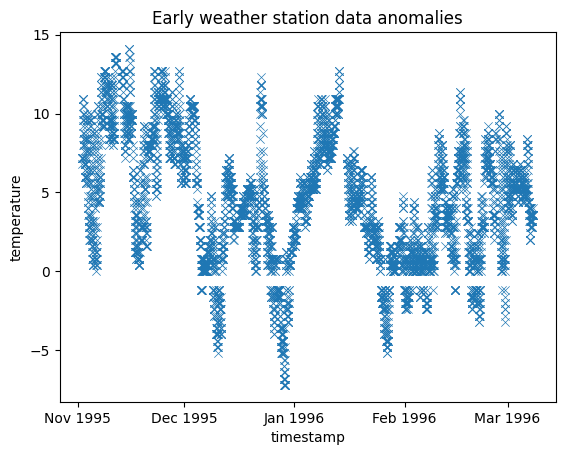

In [44]:
# We can slice the dataframe; if we use a numeric slice, we can select a subset of its rows by offset.
# We don't need to do this, but with 500k rows, it makes the plot quicker and focuses on the problem.
ax_gap = sns.scatterplot(data=df[6000:12000], x='timestamp', y='temperature', marker="x")
ax_gap.set_title("Early weather station data anomalies")

# We can neaten up the axes, not strictly necessary:
ax_gap.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator(minticks=4, maxticks=6))
ax_gap.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))

Dataframe slices don't have to be numeric, either. We can make boolean slices, where we apply a condition to the dataframe to get a mask we can later use to filter to rows matching that condition.

This can be useful for restricting the ranges of values (either to plot a particular range, say, or to remove outliers).

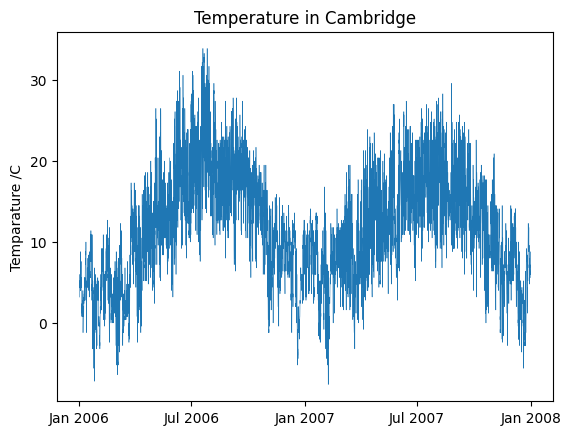

In [53]:
# Make some masks, to select only rows meeting the criteria:
post_2006 = df["timestamp"] >= datetime.datetime(2006, 1, 1)
pre_2008 = df["timestamp"] < datetime.datetime(2008, 1, 1)

ax_2006_2008 = sns.lineplot(data=df[post_2006 & pre_2008], x='timestamp', y='temperature', lw=0.4)
ax_2006_2008.set(title="Temperature in Cambridge", xlabel=None, ylabel="Temparature /C")
ax_2006_2008.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator(minticks=3, maxticks=7))
ax_2006_2008.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))

We can view and remove outliers from some data, too:

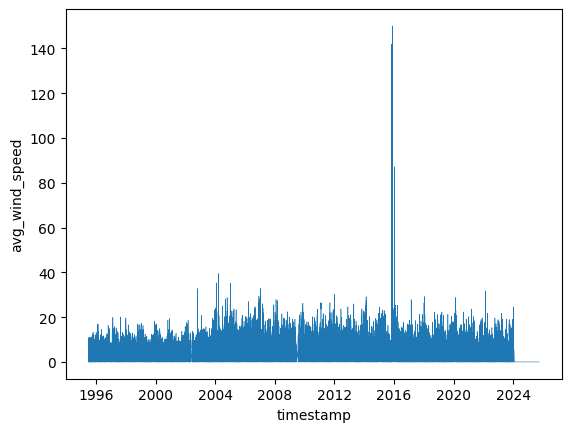

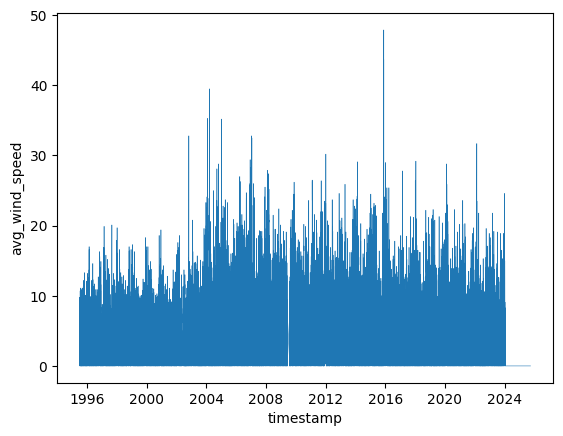

In [54]:
ax_wind_speed_raw = sns.lineplot(data=df, x='timestamp', y='avg_wind_speed', lw=0.4)

plt.figure()  # Plot next thing on new axes

no_windspd_outliers = df["avg_wind_speed"] < 50
ax_wind_speed = sns.lineplot(data=df[no_windspd_outliers], x='timestamp', y='avg_wind_speed', lw=0.4)
# Is the spike in average to ~50 knots over 30 mins seen in 2016 an error or not?

Datframes support operations to group data, and have helper functions for grouping by date ranges. Grouping by `MS` here means by "month start".

(Note that these are not quite _average_ monthly temperatures; they are averages of half-hourly averages).

In [57]:
temperatures = df[["timestamp", "temperature"]]
mean_monthly_temps = temperatures.groupby(pd.Grouper(key='timestamp', freq='MS')).mean()
print(mean_monthly_temps[-24:].to_string())

            temperature
timestamp              
2023-10-01    11.259728
2023-11-01     5.678656
2023-12-01     5.782661
2024-01-01     4.172884
2024-02-01     6.607692
2024-03-01     7.008401
2024-04-01     8.526111
2024-05-01    12.742876
2024-06-01    14.038611
2024-07-01    16.180511
2024-08-01    17.367431
2024-09-01    13.347639
2024-10-01    10.253639
2024-11-01     6.006528
2024-12-01     5.417137
2025-01-01     1.980376
2025-02-01     3.309449
2025-03-01     6.376395
2025-04-01     9.580139
2025-05-01    12.434610
2025-06-01    17.473194
2025-07-01    18.116465
2025-08-01    17.258737
2025-09-01    13.649044


---

## Explore

Some things to explore in the data:

 - By plotting some suitable charts, can you work out the extent of the period in 2016 when incorrect data was recorded?
    - Which sensors were not affected?
 - Can you work out when the pressure and humidity sensors failed?
 - What is the average temperature in Cambridge?
 - When was the rainfall data complete nonsense? (Hint: negative rain isn't possible!)